In [338]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import pyrothermel
from nfdrs4_moisture import compute_nfdrs4
from NG_FWI import hFWI
from model_comparison import fetch_meteo_data, compute_fwi_system

In [2]:
torange = (1.0, 0.4980392156862745, 0.054901960784313725)
tblue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
tgreen = (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
tpurple = (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
tpink = (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
tgrey = (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
tred = (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)

In [3]:
def compute_fmcs(dfr, lon, lat):
    nfd = compute_nfdrs4(dfr)
    nfd_fmc_cols = [x for x in nfd.columns if x.startswith("dmc_")]
    nfd_fmc_cols += ['lmc_herb', 'lmc_woody']
    nfd.loc[:, nfd_fmc_cols] *=100
    nfd_fmc_cols += ['date']
    fwi_h = compute_fwi_system(dfr, lon, lat)
    res = dfr.merge(nfd[nfd_fmc_cols], on='date', how='left')
    res = res.merge(fwi_h, on='date', how='left')
    return res

In [135]:
lat = 41.9783
lon = -7.495
start_date = '2025-01-01'
end_date = '2025-12-31'


In [136]:
dfr = fetch_meteo_data(lat, lon, start_date, end_date)

{'latitude': 41.9783, 'longitude': -7.495, 'start_date': '2025-01-01', 'end_date': '2025-12-31', 'hourly': ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'vapour_pressure_deficit', 'shortwave_radiation', 'global_tilted_irradiance'], 'tilt': 4.9293006035608435, 'azimuth': 14.931417178137536}


In [137]:
res = compute_fmcs(dfr, lon, lat)


########
Startup values used:
FFMC = 85.0 or mcffmc = None %
DMC = 6.0 and DC = 15.0
mcgfmc matted = 16.3075 % and standing = 16.3075 %
cumulative precipitation = 0.0 mm and canopy drying = 0 

Running 1 for 2025
########



In [7]:
res.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'cloud_cover', 'wind_speed_10m', 'vapour_pressure_deficit',
       'shortwave_radiation', 'global_tilted_irradiance', 'utc_offset',
       'Temperature(F)', 'RelativeHumidity(%)', 'Precipitation(in)',
       'SolarRadiation(W/m2)', 'WindSpeed(mph)', 'SnowFlag', 'DateTime',
       'dmc_1_hr', 'dmc_10_hr', 'dmc_100_hr', 'dmc_1000_hr', 'lmc_herb',
       'lmc_woody', 'lat', 'long', 'timezone', 'temp', 'rh', 'ws', 'prec',
       'grass_fuel_load', 'percent_cured', 'solrad', 'sunrise', 'sunset',
       'sunlight_hours', 'mcffmc', 'ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi',
       'dsr', 'mcgfmc_matted', 'mcgfmc_standing', 'gfmc', 'gsi', 'gfwi',
       'prec_cumulative', 'canopy_drying'],
      dtype='str')

In [29]:
res.dmc_100_hr.max()

np.float64(33.10805484441081)

In [26]:
dfr['Precipitation(in)'].max()

np.float32(0.63385826)

In [146]:
moisture = pyrothermel.MoistureScenario.from_existing(dead_fuel_moisture_class='low',live_fuel_moisture_class='moderate')
fuel = pyrothermel.FuelModel.from_existing(identifier='SH5')
canopy_base_height = 2.5 # default unit is m
canopy_bulk_density = .1 # default unit is kg/m^3

In [147]:
print([fuel.fuel_load_one_hour, fuel.fuel_load_ten_hour, fuel.fuel_load_hundred_hour])
print(fuel.units.loading_units)

[0.8070128324600083, 0.4707574856016715, 0.0]
LoadingUnitsEnum.KilogramsPerSquareMeter


In [148]:
moisture

MoistureScenario({'moisture_one_hour': 0.06, 'moisture_ten_hour': 0.07, 'moisture_hundred_hour': 0.08, 'moisture_live_herbaceous': 0.9, 'moisture_live_woody': 1.2, 'foliar_moisture': 1, 'units': <FractionUnitsEnum.Fraction: 0>}

In [149]:
ros_nfdrs4_res = []
ros_fwi_res = []
for nr, row in res.iterrows():
    moisture.moisture_ten_hour = row.dmc_10_hr / 100
    moisture.moisture_hundred_hour = row.dmc_100_hr / 100
    moisture.moisture_live_herbaceous = row.lmc_herb / 100
    moisture.moisture_live_woody = row.lmc_woody / 100
    run = pyrothermel.PyrothermelRun(fuel,moisture,row.wind_speed_10m,wind_input_mode='ten_meter',canopy_base_height=canopy_base_height,canopy_bulk_density=canopy_bulk_density,canopy_cover=.5,canopy_height=20,canopy_ratio=.6)
    results_surface = run.run_surface_fire_in_direction_of_max_spread()
    ros_nfdrs4_res.append(results_surface)
    moisture.moisture_one_hour = row.mcffmc / 100
    run = pyrothermel.PyrothermelRun(fuel,moisture,row.wind_speed_10m,wind_input_mode='ten_meter',canopy_base_height=canopy_base_height,canopy_bulk_density=canopy_bulk_density,canopy_cover=.5,canopy_height=20,canopy_ratio=.6)
    results_surface_fwi = run.run_surface_fire_in_direction_of_max_spread()
    ros_fwi_res.append(results_surface_fwi)
ros_nfdrs = pd.DataFrame(ros_nfdrs4_res)
ros_fwi = pd.DataFrame(ros_fwi_res)

In [189]:
res['ros_nfdrs'] = ros_nfdrs['spread_rate']
res['fi_nfdrs'] = ros_nfdrs['fireline_intensity']
res['fl_nfdrs'] = ros_nfdrs['flame_length']
res['ros_fwi'] = ros_fwi['spread_rate']
res['fi_fwi'] = ros_fwi['fireline_intensity']
res['ros_diff'] = res['ros_nfdrs'] - res['ros_fwi']
res['fl_fwi'] = ros_fwi['flame_length']

In [188]:
ros_nfdrs.columns

Index(['spread_rate', 'flame_length', 'fireline_intensity',
       'reaction_intensity', 'scorch_height', 'midflame_windspeed',
       'direction'],
      dtype='str')

Text(0.5, 1.0, 'Predicted daily minimum fireline intensity for 2025 at the BA 278379 location')

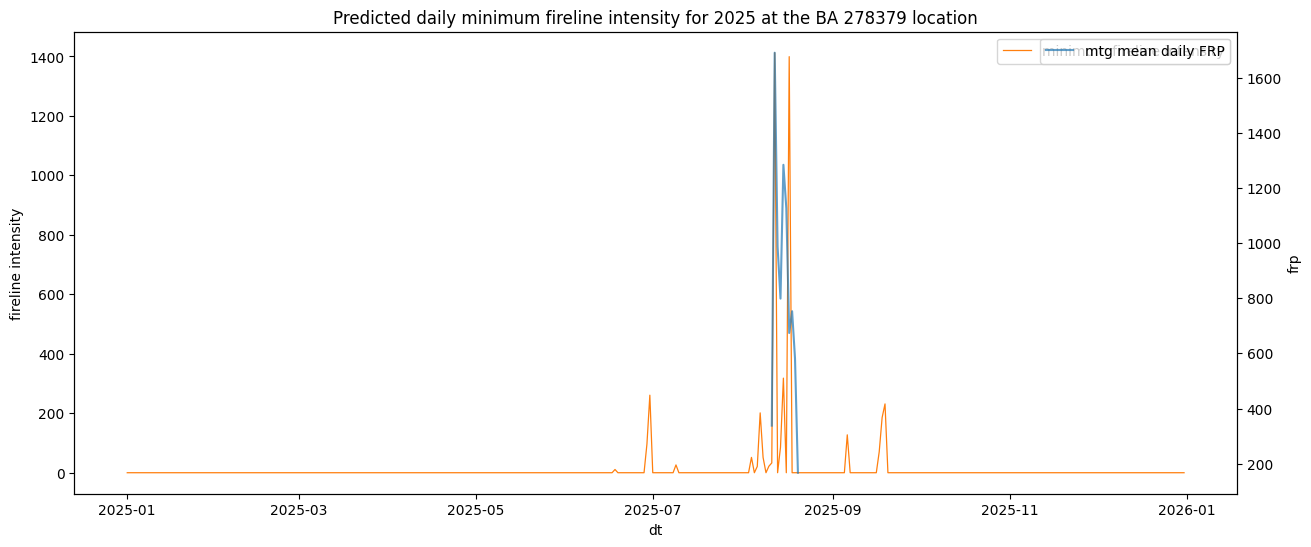

In [303]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

ressd = res.groupby(res.date.dt.date)[['fi_nfdrs', ]].min().reset_index()
resmtg = mtg.groupby(mtg.date.dt.date)[['frp', ]].mean().reset_index()
ressd['dt'] = pd.to_datetime(ressd.date)
resmtg['dt'] = pd.to_datetime(resmtg.date)
ressd = ressd.merge(resmtg, on='dt', how='left')
sns.lineplot(data=ressd, x='dt', y='frp',alpha=0.7, label='mtg mean daily FRP')
sns.lineplot(data=ressd, x='dt', y='fi_nfdrs', color=torange, linewidth=0.9, ax=ax, label='minimum fireline intensity')
#sns.lineplot(data=ressd, x='dt', y='frp', label='mtg mean daily FRP')
#sns.lineplot(data=res, x='date', y='precipitation', color=tgreen, linewidth=0.5, ax=ax, label='CFFDRS ROS')
#sns.lineplot(data=res, x='date', y='ros_diff', color=tred, linewidth=0.5, ax=ax, label='ROS diff')
ax.set_ylabel('fireline intensity')
ax.set_title('Predicted daily minimum fireline intensity for 2025 at the BA 278379 location')
#ax.set_xlim(pd.Timestamp('2025-07-15 00:00:00'), pd.Timestamp('2025-08-28 00:00:00'))

In [255]:
mtg = pd.read_csv('/media/sf_shared/df_mtg.csv', parse_dates=['acq_at'])
mtg['date'] = mtg['acq_at'].dt.round('h')
mtg['date'] = mtg['date'].dt.tz_localize('UTC')
mtg['frp'] = mtg['frp']*1000000
mtg_res= mtg.merge(res[['date', 'fl_nfdrs']], on='date', how='left')

In [293]:
ressd.fillna(0)

,date_x,fi_nfdrs,dt,date_y,frp
0,2025-01-01,0.0,2025-01-01,0,0.0
1,2025-01-02,0.0,2025-01-02,0,0.0
2,2025-01-03,0.0,2025-01-03,0,0.0
3,2025-01-04,0.0,2025-01-04,0,0.0
4,2025-01-05,0.0,2025-01-05,0,0.0
...,...,...,...,...,...
360,2025-12-27,0.0,2025-12-27,0,0.0
361,2025-12-28,0.0,2025-12-28,0,0.0
362,2025-12-29,0.0,2025-12-29,0,0.0
363,2025-12-30,0.0,2025-12-30,0,0.0


Text(0.5, 1.0, 'Predicted fire behaviour for EFFIS BA id 278348, fuel model SH5 (high load dry climate shrub)')

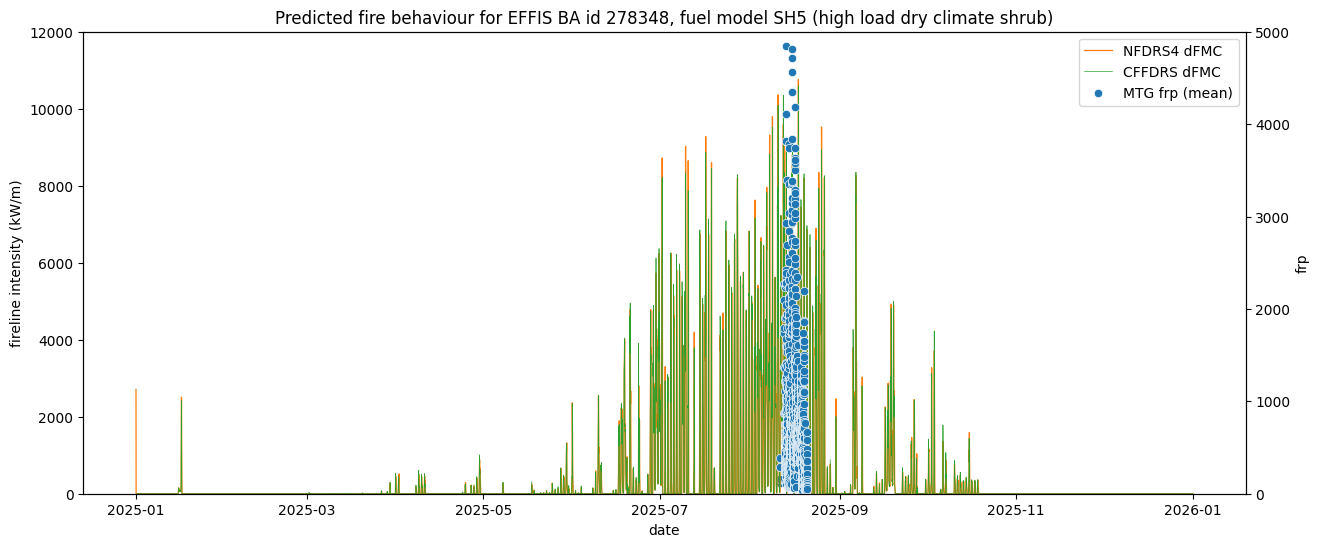

In [269]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
#ressd = ress.groupby(ress.date.dt.date)[['dmc_1_hr', 'dmc_10_hr', 'mcffmc', 'mcgfmc_matted']].min()
sns.lineplot(data=res, x='date', y='fi_nfdrs', color=torange, linewidth=0.9, ax=ax, label='NFDRS4 dFMC')
sns.lineplot(data=res, x='date', y='fi_fwi', color=tgreen, linewidth=0.5, ax=ax, label='CFFDRS dFMC')
sns.scatterplot(data=mtg.iloc[:2], x='acq_at', y='frp', ax=ax, label='MTG frp (mean)')
sns.scatterplot(data=mtg, x='acq_at', y='frp', ax=ax2)
ax.set_ylabel('fireline intensity (kW/m)')
ax.set_ylim(0, 12000)
ax2.set_ylim(0,5000)
#ax2.legend(loc=1)
ax.set_title('Predicted fire behaviour for EFFIS BA id 278348, fuel model SH5 (high load dry climate shrub)')
#ax.set_xlim(pd.Timestamp('2025-08-09 00:00:00'), pd.Timestamp('2025-08-25 00:00:00'))
#fig.savefig('/media/sf_shared/mtg_fireline_intensity_id_278378_all_year.png', dpi=300, bbox_inches="tight")

In [304]:
def behaviour_at_point(lat, lon, start_date, end_date):
    dfr = fetch_meteo_data(lat, lon, start_date, end_date)
    res = compute_fmcs(dfr, lon, lat)
    ros_nfdrs4_res = []
    ros_fwi_res = []
    for nr, row in res.iterrows():
        moisture.moisture_ten_hour = row.dmc_10_hr / 100
        moisture.moisture_hundred_hour = row.dmc_100_hr / 100
        moisture.moisture_live_herbaceous = row.lmc_herb / 100
        moisture.moisture_live_woody = row.lmc_woody / 100
        run = pyrothermel.PyrothermelRun(fuel,moisture,row.wind_speed_10m,wind_input_mode='ten_meter',canopy_base_height=canopy_base_height,canopy_bulk_density=canopy_bulk_density,canopy_cover=.5,canopy_height=20,canopy_ratio=.6)
        results_surface = run.run_surface_fire_in_direction_of_max_spread()
        ros_nfdrs4_res.append(results_surface)
        moisture.moisture_one_hour = row.mcffmc / 100
        run = pyrothermel.PyrothermelRun(fuel,moisture,row.wind_speed_10m,wind_input_mode='ten_meter',canopy_base_height=canopy_base_height,canopy_bulk_density=canopy_bulk_density,canopy_cover=.5,canopy_height=20,canopy_ratio=.6)
        results_surface_fwi = run.run_surface_fire_in_direction_of_max_spread()
        ros_fwi_res.append(results_surface_fwi)
    ros_nfdrs = pd.DataFrame(ros_nfdrs4_res)
    ros_fwi = pd.DataFrame(ros_fwi_res)
    
    res['ros_nfdrs'] = ros_nfdrs['spread_rate']
    res['fi_nfdrs'] = ros_nfdrs['fireline_intensity']
    res['fl_nfdrs'] = ros_nfdrs['flame_length']
    res['ros_fwi'] = ros_fwi['spread_rate']
    res['fi_fwi'] = ros_fwi['fireline_intensity']
    res['ros_diff'] = res['ros_nfdrs'] - res['ros_fwi']
    res['fl_fwi'] = ros_fwi['flame_length']
    return res

In [305]:
lat = 40.20042
lon = -5.88582
start_date = '2025-01-01'
end_date = '2025-12-31'
bres = behaviour_at_point(lat, lon, start_date, end_date) 

{'latitude': 40.20042, 'longitude': -5.88582, 'start_date': '2025-01-01', 'end_date': '2025-12-31', 'hourly': ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'vapour_pressure_deficit', 'shortwave_radiation', 'global_tilted_irradiance'], 'tilt': 16.158539911157366, 'azimuth': -147.52880770915152}

########
Startup values used:
FFMC = 85.0 or mcffmc = None %
DMC = 6.0 and DC = 15.0
mcgfmc matted = 16.3075 % and standing = 16.3075 %
cumulative precipitation = 0.0 mm and canopy drying = 0 

Running 1 for 2025
########



In [314]:
mtg = pd.read_csv('/media/sf_shared/df_mtg_ba_279768.csv', parse_dates=['acq_at'])
mtg['date'] = mtg['acq_at'].dt.round('h')
mtg['date'] = mtg['date'].dt.tz_localize('UTC')
#mtg['frp'] = mtg['frp']*1000000
mtg_h = mtg.groupby('date')['frp'].mean().reset_index()

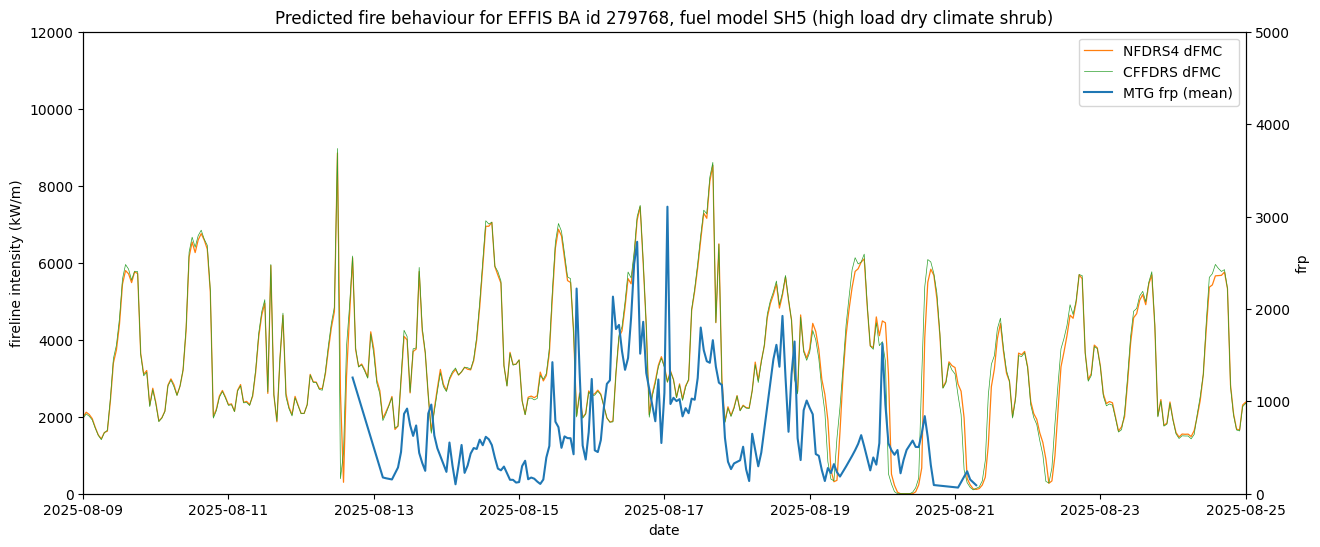

In [322]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
sns.lineplot(data=bres, x='date', y='fi_nfdrs', color=torange, linewidth=0.9, ax=ax, label='NFDRS4 dFMC')
sns.lineplot(data=bres, x='date', y='fi_fwi', color=tgreen, linewidth=0.5, ax=ax, label='CFFDRS dFMC')
#sns.scatterplot(data=mtg.iloc[:2], x='acq_at', y='frp', ax=ax, label='MTG frp (mean)')
#sns.scatterplot(data=mtg, x='acq_at', y='frp', ax=ax2)
sns.lineplot(data=mtg.iloc[:1], x='date', y='frp', ax=ax, label='MTG frp (mean)')
sns.lineplot(data=mtg_h, x='date', y='frp', ax=ax2)
ax.set_ylabel('fireline intensity (kW/m)')
ax.set_ylim(0, 12000)
ax2.set_ylim(0,5000)
#ax2.legend(loc=1)
ax.set_title('Predicted fire behaviour for EFFIS BA id 279768, fuel model SH5 (high load dry climate shrub)')
ax.set_xlim(pd.Timestamp('2025-08-09 00:00:00'), pd.Timestamp('2025-08-25 00:00:00'))
fig.savefig('/media/sf_shared/mtg_fireline_intensity_id_279768.png', dpi=300, bbox_inches="tight")

Text(0.5, 1.0, 'Predicted daily minimum fireline intensity for 2025 at the BA 279768 location')

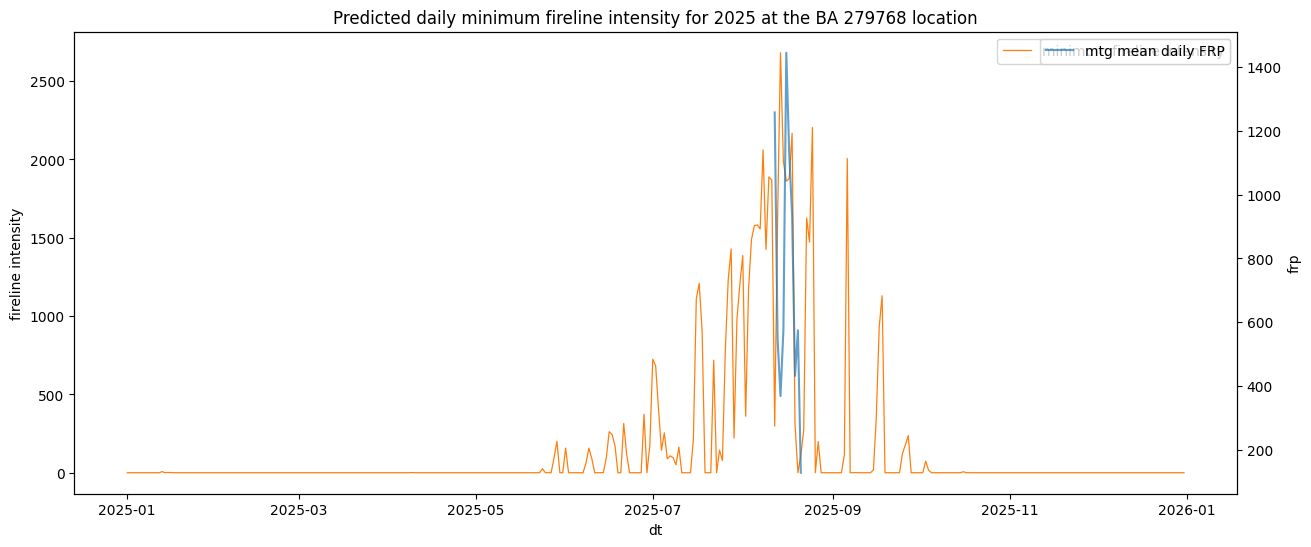

In [321]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ressd = bres.groupby(bres.date.dt.date)[['fi_nfdrs', ]].min().reset_index()
resmtg = mtg.groupby(mtg.date.dt.date)[['frp', ]].mean().reset_index()
ressd['dt'] = pd.to_datetime(ressd.date)
resmtg['dt'] = pd.to_datetime(resmtg.date)
ressd = ressd.merge(resmtg, on='dt', how='left')
sns.lineplot(data=ressd, x='dt', y='frp',alpha=0.7, label='mtg mean daily FRP')
sns.lineplot(data=ressd, x='dt', y='fi_nfdrs', color=torange, linewidth=0.9, ax=ax, label='minimum fireline intensity')
#sns.lineplot(data=ressd, x='dt', y='frp', label='mtg mean daily FRP')
#sns.lineplot(data=res, x='date', y='precipitation', color=tgreen, linewidth=0.5, ax=ax, label='CFFDRS ROS')
#sns.lineplot(data=res, x='date', y='ros_diff', color=tred, linewidth=0.5, ax=ax, label='ROS diff')
ax.set_ylabel('fireline intensity')
ax.set_title('Predicted daily minimum fireline intensity for 2025 at the BA 279768 location')
#ax.set_xlim(pd.Timestamp('2025-07-15 00:00:00'), pd.Timestamp('2025-08-28 00:00:00'))

In [323]:
42.82965,18.15599
lat = 42.82965
lon = 18.15599
start_date = '2025-01-01'
end_date = '2025-12-31'
bres = behaviour_at_point(lat, lon, start_date, end_date) 

{'latitude': 42.82965, 'longitude': 18.15599, 'start_date': '2025-01-01', 'end_date': '2025-12-31', 'hourly': ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'vapour_pressure_deficit', 'shortwave_radiation', 'global_tilted_irradiance'], 'tilt': 15.176669955014779, 'azimuth': -145.00797980144134}

########
Startup values used:
FFMC = 85.0 or mcffmc = None %
DMC = 6.0 and DC = 15.0
mcgfmc matted = 16.3075 % and standing = 16.3075 %
cumulative precipitation = 0.0 mm and canopy drying = 0 

Running 1 for 2025
########



In [327]:
mtg = pd.read_csv('/media/sf_shared/df_mtg_ba_273988.csv', parse_dates=['acq_at'])
mtg['date'] = mtg['acq_at'].dt.round('h')
mtg['date'] = mtg['date'].dt.tz_localize('UTC')
mtg_h = mtg.groupby('date')['frp'].mean().reset_index()

In [339]:
virs = gpd.read_file('/media/sf_shared/VIIRS_BA_273988.gpkg')

In [340]:
virs

,id,frp,acq_at,satellite,geometry
0,33390992711,25,2025-07-05 12:06:00,1,POINT (18.23692 42.85745)
1,33530283769,140,2025-07-09 08:56:00,T,POINT (18.12353 42.82753)
2,33541511124,56,2025-07-09 12:08:00,N,POINT (18.11574 42.82559)
3,33541511144,491,2025-07-09 12:08:00,N,POINT (18.11943 42.82594)
4,33541511161,491,2025-07-09 12:08:00,N,POINT (18.12312 42.82628)
...,...,...,...,...,...
568,33854660891,6,2025-07-18 01:37:00,1,POINT (18.14207 42.8322)
569,33854660905,8,2025-07-18 01:37:00,1,POINT (18.13926 42.83244)
570,33854660924,9,2025-07-18 01:37:00,1,POINT (18.18024 42.83254)
571,33854660941,5,2025-07-18 01:37:00,1,POINT (18.18253 42.83268)


In [331]:
bres.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'cloud_cover', 'wind_speed_10m', 'vapour_pressure_deficit',
       'shortwave_radiation', 'global_tilted_irradiance', 'utc_offset',
       'Temperature(F)', 'RelativeHumidity(%)', 'Precipitation(in)',
       'SolarRadiation(W/m2)', 'WindSpeed(mph)', 'SnowFlag', 'DateTime',
       'dmc_1_hr', 'dmc_10_hr', 'dmc_100_hr', 'dmc_1000_hr', 'lmc_herb',
       'lmc_woody', 'lat', 'long', 'timezone', 'temp', 'rh', 'ws', 'prec',
       'grass_fuel_load', 'percent_cured', 'solrad', 'sunrise', 'sunset',
       'sunlight_hours', 'mcffmc', 'ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi',
       'dsr', 'mcgfmc_matted', 'mcgfmc_standing', 'gfmc', 'gsi', 'gfwi',
       'prec_cumulative', 'canopy_drying', 'ros_nfdrs', 'fi_nfdrs', 'fl_nfdrs',
       'ros_fwi', 'fi_fwi', 'ros_diff', 'fl_fwi'],
      dtype='str')

(np.float64(20274.0), np.float64(20290.0))

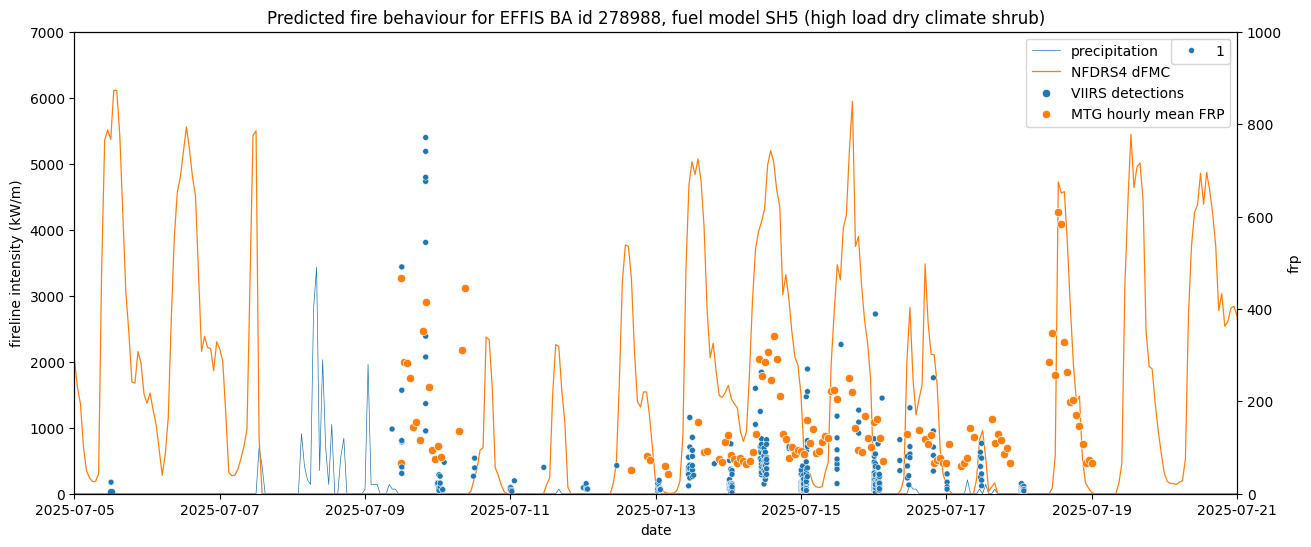

In [377]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
bres['prec'] = bres['precipitation'] * 700
sns.lineplot(data=bres, x='date', y='prec', color=tblue, linewidth=0.5, ax=ax, label='precipitation')
sns.lineplot(data=bres, x='date', y='fi_nfdrs', color=torange, linewidth=0.9, ax=ax, label='NFDRS4 dFMC')
#sns.lineplot(data=bres, x='date', y='fi_fwi', color=tgreen, linewidth=0.5, ax=ax, label='CFFDRS dFMC')
#sns.scatterplot(data=mtg.iloc[:2], x='acq_at', y='frp', ax=ax, label='MTG frp (mean)')
sns.scatterplot(data=virs, x='acq_at', y='frp', size=1, ax=ax2)
sns.scatterplot(data=virs.iloc[:1], x='acq_at', y='frp',  ax=ax, label='VIIRS detections')
sns.scatterplot(data=mtg_h, x='date', y='frp', ax=ax2)
sns.scatterplot(data=mtg_h.iloc[:1], x='date', y='frp',  ax=ax, label='MTG hourly mean FRP')
ax.set_ylabel('fireline intensity (kW/m)')
ax.set_ylim(0, 7000)
ax2.set_ylim(0,1000)
#ax2.legend(loc=1)
ax.set_title('Predicted fire behaviour for EFFIS BA id 278988, fuel model SH5 (high load dry climate shrub)')
ax.set_xlim(pd.Timestamp('2025-07-05 00:00:00'), pd.Timestamp('2025-07-21 00:00:00'))
#fig.savefig('/media/sf_shared/mtg_fireline_intensity_id_279768.png', dpi=300, bbox_inches="tight")

<Axes: xlabel='date', ylabel='percent_cured'>

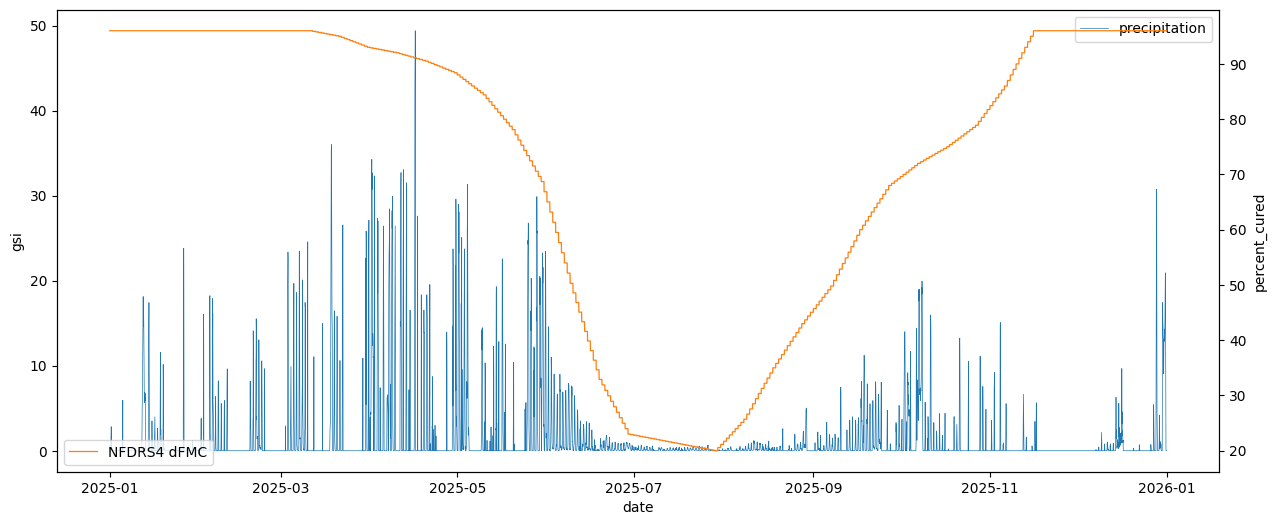

In [390]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
bres['prec'] = bres['precipitation'] * 700
sns.lineplot(data=bres, x='date', y='gsi', color=tblue, linewidth=0.5, ax=ax, label='precipitation')
sns.lineplot(data=bres, x='date', y='percent_cured', color=torange, linewidth=0.9, ax=ax2, label='NFDRS4 dFMC')
#ax.set_ylim(0, 50)
#ax.set_xlim(pd.Timestamp('2025-07-05 00:00:00'), pd.Timestamp('2025-07-21 00:00:00'))

In [363]:
bres.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'cloud_cover', 'wind_speed_10m', 'vapour_pressure_deficit',
       'shortwave_radiation', 'global_tilted_irradiance', 'utc_offset',
       'Temperature(F)', 'RelativeHumidity(%)', 'Precipitation(in)',
       'SolarRadiation(W/m2)', 'WindSpeed(mph)', 'SnowFlag', 'DateTime',
       'dmc_1_hr', 'dmc_10_hr', 'dmc_100_hr', 'dmc_1000_hr', 'lmc_herb',
       'lmc_woody', 'lat', 'long', 'timezone', 'temp', 'rh', 'ws', 'prec',
       'grass_fuel_load', 'percent_cured', 'solrad', 'sunrise', 'sunset',
       'sunlight_hours', 'mcffmc', 'ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi',
       'dsr', 'mcgfmc_matted', 'mcgfmc_standing', 'gfmc', 'gsi', 'gfwi',
       'prec_cumulative', 'canopy_drying', 'ros_nfdrs', 'fi_nfdrs', 'fl_nfdrs',
       'ros_fwi', 'fi_fwi', 'ros_diff', 'fl_fwi'],
      dtype='str')

(np.float64(20309.0), np.float64(20323.0))

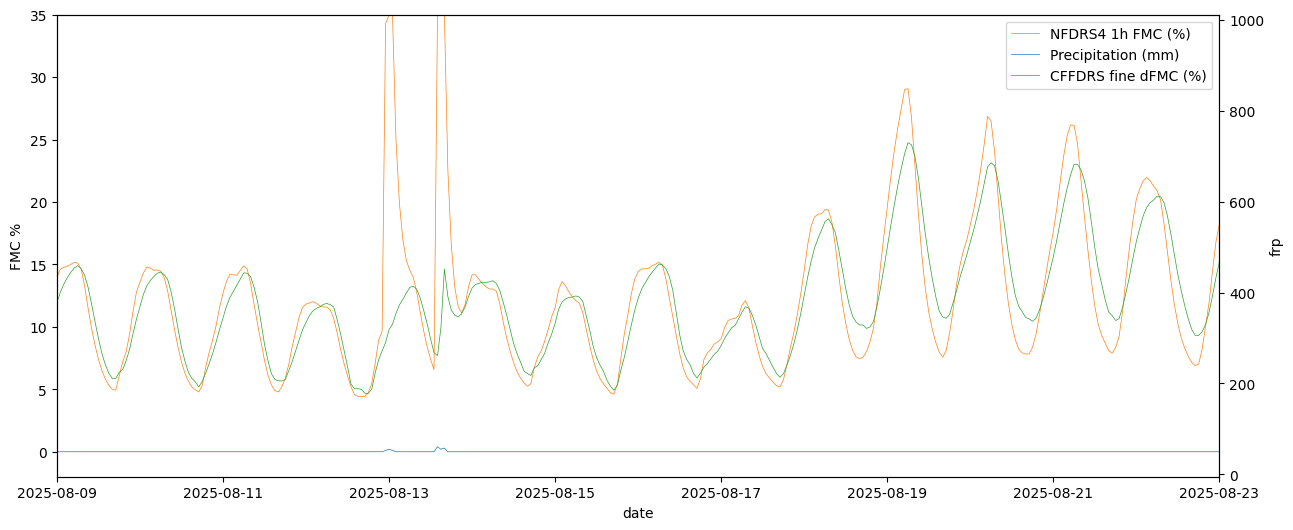

In [334]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
#ressd = ress.groupby(ress.date.dt.date)[['dmc_1_hr', 'dmc_10_hr', 'mcffmc', 'mcgfmc_matted']].min()
sns.lineplot(data=res, x='date', y='dmc_1_hr', color=torange, linewidth=0.5, ax=ax, label='NFDRS4 1h FMC (%)')
sns.lineplot(data=res, x='date', y='precipitation', color=tblue, linewidth=0.5, ax=ax, label='Precipitation (mm)')
sns.lineplot(data=res, x='date', y='mcffmc', color=tgreen, linewidth=0.5, ax=ax, label='CFFDRS fine dFMC (%)')
sns.scatterplot(data=mtg, x='acq_at', y='frp', ax=ax2)
ax.set_ylim(-2, 35)
ax.set_ylabel('FMC %')
#ax.set_xlim(pd.Timestamp('2025-07-15 00:00:00'), pd.Timestamp('2025-08-28 00:00:00'))
ax.set_xlim(pd.Timestamp('2025-08-09 00:00:00'), pd.Timestamp('2025-08-23 00:00:00'))

In [172]:
mtg.acq_at[0]

Timestamp('2025-08-11 11:48:37')

In [87]:
moisture = pyrothermel.MoistureScenario.from_existing(dead_fuel_moisture_class='low',live_fuel_moisture_class='moderate')
fuel = pyrothermel.FuelModel.from_existing(identifier='SH6')
ros_nfdrs4_res = []
run = pyrothermel.PyrothermelRun(fuel,moisture,row.wind_speed_10m,wind_input_mode='ten_meter',canopy_base_height=canopy_base_height,canopy_bulk_density=canopy_bulk_density,canopy_cover=.5,canopy_height=20,canopy_ratio=.6)
for nr, row in res.iterrows():
    run.moisture_scenario.moisture_one_hour = row.dmc_1_hr / 100
    run.moisture_scenario.moisture_ten_hour = row.dmc_10_hr / 100
    run.moisture_scenario.moisture_hundred_hour = row.dmc_100_hr / 100
    run.moisture_scenario.moisture_live_herbaceous = row.lmc_herb / 100
    run.moisture_scenario.moisture_live_woody = row.lmc_woody / 100
    #run = pyrothermel.PyrothermelRun(fuel,moisture,row.wind_speed_10m,wind_input_mode='ten_meter',canopy_base_height=canopy_base_height,canopy_bulk_density=canopy_bulk_density,canopy_cover=.5,canopy_height=20,canopy_ratio=.6)
    results_surface = run.run_surface_fire_in_direction_of_max_spread()
    ros_nfdrs4_res.append(results_surface)
ros_nfdrs = pd.DataFrame(ros_nfdrs4_res)

In [88]:
moisture = pyrothermel.MoistureScenario.from_existing(dead_fuel_moisture_class='low',live_fuel_moisture_class='moderate')
fuel = pyrothermel.FuelModel.from_existing(identifier='SH6')
ros_cffdrs_res = []
run = pyrothermel.PyrothermelRun(fuel,moisture,row.wind_speed_10m,wind_input_mode='ten_meter',canopy_base_height=canopy_base_height,canopy_bulk_density=canopy_bulk_density,canopy_cover=.5,canopy_height=20,canopy_ratio=.6)
for nr, row in res.iterrows():
    run.moisture_scenario.moisture_one_hour = row.mcffmc / 100
    run.moisture_scenario.moisture_ten_hour = row.dmc_10_hr / 100
    run.moisture_scenario.moisture_hundred_hour = row.dmc_100_hr / 100
    run.moisture_scenario.moisture_live_herbaceous = row.lmc_herb / 100
    run.moisture_scenario.moisture_live_woody = row.lmc_woody / 100
    #run = pyrothermel.PyrothermelRun(fuel,moisture,row.wind_speed_10m,wind_input_mode='ten_meter',canopy_base_height=canopy_base_height,canopy_bulk_density=canopy_bulk_density,canopy_cover=.5,canopy_height=20,canopy_ratio=.6)
    results_surface = run.run_surface_fire_in_direction_of_max_spread()
    ros_cffdrs_res.append(results_surface)
ros_fwi = pd.DataFrame(ros_cffdrs_res)

In [132]:
pyrothermel.PyrothermelRun.run_surface_fire_in_direction_of_max_spread?

Signature:
pyrothermel.PyrothermelRun.run_surface_fire_in_direction_of_max_spread(
    self,
) -> dict
Docstring:
Runs SURFACE module from behave, adds results to PyrothermelRun object as properties and returns dictionary with results.

Args:
    None

Returns:
    spread_rate: surface fire rate of spread. Default unit is km/hr for metric, chains/hr for US
    flame_length: surface fire flame length. Default unit is m for metric, feet for US.
    fireline_intensity: Byram's fireline intensity. Default unit is kW/m for metric, btus/ft/s for US.
    reaction_intensity: Fireline reaction intensity. Default unit is kW/m^2 for metric, btus/ft^2/s for US.
    scorch_height: Canopy scorch height from surface fire. Default unit is m for metric, feet for US.
    midflame_windspeed: Adjusted midflame windspeed. Default unit is km/hr for metric, mi/hr for US.
    direction: Direction of maximum spread relative to North
File:      ~/repos/fuel-moisture/.venv/lib/python3.13/site-packages/pyrotherme

In [116]:
run.update_inputs?

Signature:
run.update_inputs(
    fuel_model=None,
    moisture_scenario=None,
    wind_speed=None,
    units_preset=None,
    wind_input_mode=None,
    wind_direction=None,
    slope=None,
    aspect=None,
    air_temperature=None,
    canopy_base_height=None,
    canopy_bulk_density=None,
    canopy_cover=None,
    canopy_height=None,
    canopy_ratio=None,
)
Docstring:
Update one or more input values.

Args:
    fuel_model (FuelModel): FuelModel object containing fuel loading values
    moisture_scenario (MoistureScenario): MoistureScenario object containing fuel moisture values
    wind_speed (float): Wind speed value. Default metric unit: km/hr, default US unit: mi/hr.
    units_preset (Union[str, UnitsPreset], optional): Can be 'metric', 'us_standard', or a custom UnitsPreset object. Sets numerous input/output measurement units.
    wind_input_mode (str): Input height mode for wind. Options are 'direct_midflame', 'ten_meter', or 'twenty_foot'. If 'ten_meter' or 'twenty_foot' is u

In [121]:
pyrothermel.PyrothermelRun.update_inputs

Signature:
pyrothermel.PyrothermelRun.run_surface_fire_in_direction_of_max_spread(
    self,
) -> dict
Docstring:
Runs SURFACE module from behave, adds results to PyrothermelRun object as properties and returns dictionary with results.

Args:
    None

Returns:
    spread_rate: surface fire rate of spread. Default unit is km/hr for metric, chains/hr for US
    flame_length: surface fire flame length. Default unit is m for metric, feet for US.
    fireline_intensity: Byram's fireline intensity. Default unit is kW/m for metric, btus/ft/s for US.
    reaction_intensity: Fireline reaction intensity. Default unit is kW/m^2 for metric, btus/ft^2/s for US.
    scorch_height: Canopy scorch height from surface fire. Default unit is m for metric, feet for US.
    midflame_windspeed: Adjusted midflame windspeed. Default unit is km/hr for metric, mi/hr for US.
    direction: Direction of maximum spread relative to North
File:      ~/repos/fuel-moisture/.venv/lib/python3.13/site-packages/pyrotherme